In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import langdetect as ld

In [2]:
df = pd.read_csv('data/book_data.csv')

In [ ]:
df = df.dropna(subset=['genres']) # drop nans in genre

In [21]:
# detect language
lang = []
for text in df.book_desc:
    try:
        l = ld.detect(text)
        lang.append(l)
    except (TypeError, ld.LangDetectException): # no features in text
        lang.append('') 

In [26]:
df['lang'] = lang
df = df[df['lang'] == 'en'] # remove nonenglish texts

In [31]:
# remove useless features
to_remove = ['book_edition', 'book_isbn', 'image_url', 'lang']
for feat in to_remove:
    del df[feat]

In [39]:
# list all genres
all_genres = []
for gs in df.genres:
    gs_list = gs.split('|')
    all_genres.extend(gs_list)

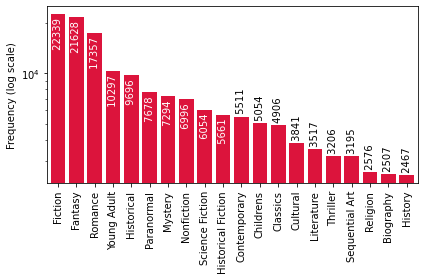

In [124]:
from collections import Counter
def plot_most_common(values, n):
    freq = Counter(values).most_common(n)
    y = [count for tag, count in freq]
    x = [tag for tag, count in freq]

    plt.bar(x, y, color='crimson')
    plt.ylabel("Frequency (log scale)")
    plt.yscale('log') # optionally set a log scale for the y-axis
    plt.xticks(rotation=90)
    for i, (tag, count) in enumerate(freq):
        plt.text(i, count, f' {count} ', rotation=90,
                 ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
    plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
    plt.tight_layout() # change the whitespace such that all labels fit nicely
    plt.savefig('plots/top_genres.png')
    plt.show()
plot_most_common(all_genres, 20)


In [64]:
encoded = dict()
for key in set(all_genres):
    encoded[key] = [0] * len(df)

In [65]:
# encode genres
for i, gs in enumerate(df.genres):
    gs_list = gs.split('|')
    for j, g in enumerate(gs_list):
        if j == 0:
            encoded[g][i] = 2
        elif j in [1,2]:
            encoded[g][i] = 1


In [66]:
genres = pd.DataFrame(encoded)

In [73]:
# filter out least important
for col in genres.columns:
    if genres[col].sum() < 100:
        del genres[col]
    if 2 in genres[col].tolist():
        pass
    else:
        del genres[col]

In [81]:
len(df) == len(genres)

True

In [84]:
final = pd.concat([df.reset_index(drop=True), genres.reset_index(drop=True)], axis=1)

In [86]:
del final['genres']

In [91]:
# fix book pages format
bookpages = lambda x: int(x.split()[0]) if isinstance(x, str) else None
final['book_pages'] = final.book_pages.apply(bookpages)

In [94]:
final.to_csv('data/books_processed.csv')

In [106]:
import tqdm

In [115]:
for i, descr in tqdm.tqdm(final.book_desc.iteritems()):
    with open(f'data/descr/{i}.txt', 'w') as file:
        file.write(descr)

43793it [00:10, 4162.60it/s]


In [119]:
for_ZSL = [] # for zero shot learning
for i, items in df.iterrows():
    authors = items['book_authors']
    title = items['book_title']
    desc = items['book_desc']
    genre = items['genres'].split('|')[0]
    
    for_ZSL.append((authors, title, desc, genre))


In [122]:
pd.DataFrame(for_ZSL, columns=['book_authors', 'book_title', 'book_desc', 'genre']).to_csv('data/to_ZSL.csv', index=False)